# DEMO: Running BiDiCAM

## Note: This code is still in testing.

                                        Combine KAR     ROAR
    FastCAM                             1.45	3.68	-2.23
    BidiCAM (plain)                     1.42	3.69	-2.28
    BidiCAM x GradCAM                   1.42	3.70	-2.28
    BidiCAM x GradCAM x Max Pooling     1.43    3.69    -2.27  
    BidiCAM x GradCAM x Avg Pooling     1.44    3.70    -2.26
    
So far, BiDiCAM is not as good as FastCAM overall. However, its KAR score is the best so far. This makes it most ideal for finding the most salient points. Most testing is still going on. 

## Initial code setup

In [1]:
import os
import torch
from torchvision import models
from IPython.display import Image

Lets load things we need for **Grad-CAM**

In [2]:
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F

# The GradCAM kit throws a warning we don't need to see for this demo. 
import warnings
warnings.filterwarnings('ignore')

Now we import the code for **this package**.

In [3]:
import maps
import mask
import misc
import bidicam

This is where we can set some parameters like the image name and the layer weights.

In [4]:
input_image_name    = "ILSVRC2012_val_00049934.224x224.png"     # 222 Kuvasz 

output_dir          = 'outputs'                                 # Where to save our output images
input_dir           = 'images'                                  # Where to load our inputs from

save_prefix         = input_image_name[:-4].split('/')[-1] + ".BiDiCAM."      # Chop the file extension and path
load_image_name     = os.path.join(input_dir, input_image_name)

os.makedirs(output_dir, exist_ok=True)

Good Doggy!

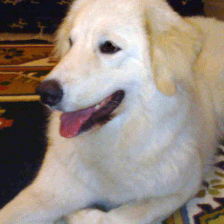

In [5]:
Image(filename=load_image_name) 

Now we create a model in PyTorch and send it to our device.

In [ ]:
device              = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model               = models.resnet50(pretrained=True)
model               = model.to(device) 

In [ ]:
do_first_forward    = False
actv_method         = maps.SMOEScaleMap
grad_method         = maps.SMOEScaleMap
interp_pooling      = 'bilinear'

#layers              = ['relu','layer1','layer2','layer3','layer4']
layers              = None

OK, now let's load in our image and set it to the standard *ImageNet* size: 224x224. 

In [ ]:
in_tensor   = misc.LoadImageToTensor(load_image_name, device)
in_tensor   = F.interpolate(in_tensor, size=(224, 224), mode='bilinear', align_corners=False)

in_height   = in_tensor.size()[2]
in_width    = in_tensor.size()[3]

In [ ]:
raw_tensor  = misc.LoadImageToTensor(load_image_name, device, norm=False)
raw_tensor  = F.interpolate(raw_tensor, size=(in_height, in_width), mode='bilinear', align_corners=False)

OK, let's run our ResNet network *forward only*. The callbacks will then contain the layer data afterwards. Since we are only doing a forward computation, this sails on a CPU. 

## Running saliency on our network data

Now that the network has run, we can finally do some work. First we create objects for our saliency layers. These are *PyTorch nn layers*, but we can talk to them even if they are not inside a network. 

In [ ]:
grad_pooling        = None
use_GradCAM         = True

bidimodel_v1        = bidicam.BiDiCAMModel(model, layers, actv_method=actv_method, grad_method=grad_method, 
                                           grad_pooling=grad_pooling, interp_pooling=interp_pooling, 
                                           use_GradCAM=use_GradCAM, do_first_forward=do_first_forward)

csmap_v1, smap_v1, logit = bidimodel_v1(in_tensor)

In [ ]:
grad_pooling        = None
use_GradCAM         = False

bidimodel_v2        = bidicam.BiDiCAMModel(model, layers, actv_method=actv_method, grad_method=grad_method, 
                                           grad_pooling=grad_pooling, interp_pooling=interp_pooling, 
                                           use_GradCAM=use_GradCAM, do_first_forward=do_first_forward)

csmap_v2, smap_v2, logit = bidimodel_v2(in_tensor)

In [ ]:
grad_pooling        = 'mag'
use_GradCAM         = True

bidimodel_v3        = bidicam.BiDiCAMModel(model, layers, actv_method=actv_method, grad_method=grad_method, 
                                           grad_pooling=grad_pooling, interp_pooling=interp_pooling, 
                                           use_GradCAM=use_GradCAM, do_first_forward=do_first_forward)

csmap_v3, smap_v3, logit = bidimodel_v3(in_tensor)

In [ ]:
grad_pooling        = 'avg'
use_GradCAM         = True

bidimodel_v4        = bidicam.BiDiCAMModel(model, layers, actv_method=actv_method, grad_method=grad_method, 
                                           grad_pooling=grad_pooling, interp_pooling=interp_pooling, 
                                           use_GradCAM=use_GradCAM, do_first_forward=do_first_forward)

csmap_v4, smap_v4, logit = bidimodel_v4(in_tensor)

In [ ]:
too_logit = logit.max(1)
print("Network Class Output: {} : Value {} ".format(too_logit[1][0],too_logit[0][0]))

Now lets get our individual saliency maps for each of the five layers and look at them. 

### Visualize It
Take the images and create a nice tiled image to look at. This will created a tiled image of:

    (1) The input image.
    (2) The saliency map.
    (3) The saliency map overlaid on the input image.
    (4) The raw image enhanced with the most salient locations.
    (5) The top 10% most salient locations. 

In [ ]:
getMask     = mask.SaliencyMaskDropout(keep_percent = 0.1, scale_map=False)

In [ ]:
images      = misc.TileOutput(raw_tensor,csmap_v1,getMask)
images      = misc.TileOutput(raw_tensor,csmap_v2,getMask,images)
images      = misc.TileOutput(raw_tensor,csmap_v3,getMask,images)
images      = misc.TileOutput(raw_tensor,csmap_v4,getMask,images)

In [ ]:
images      = make_grid(torch.cat(images,0), nrow=5)

output_name = "{}.BiDiCAM.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image(filename=output_path) 